<a href="https://colab.research.google.com/github/zhaojj1014/US_Consumption_Habits/blob/main/US_consumption_Habits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Understanding consumption habits is critical for marketers and investors. This project will explore how the U.S. consumers' behavior has evolved from 1929 to 2021.
The goal of this project is to find out:
How does consumption vary with Revenue and with other drivers ?
Are the variations in consumption mainly due to changes in one variable or many (Hypothesis Testing) ?
Do American residents adjust their consumption based on inflation during that period ?
How does the interaction between all variables and their impact on each other change between 1929 and 2021 ?

# Data Overview

- $Y$ : Consumption - in Billion USD
- $X$ : Revenue (Income) - in Billion USD
- $T$ : Trend (Time) - A sequence $[1,N]$
- $Z$ : Population - In capita
- $P$ : Consumer price index (Inflation)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary packages (You can use other ones with the same purpose)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import seaborn as sns
sns.set()


# import data
data = pd.read_csv('/content/drive/MyDrive/Lonely Octopus Projects/US Consumption Habits/Project #8 Submission (Jinjing)/ConsumptionData.csv')
data = data.rename(columns={
    "Consumption (Billion USD)": "Consumption",
    "Revenu  (Billion USD)": "Revenue"
})

In [3]:
data.head()

,Year,Consumption,Revenue,Population,Price Index,Trend
0,1929,77.4,85.3,121767000,9.391,1
1,1930,70.1,76.5,123076741,9.028,2
2,1931,60.7,65.7,124039648,8.136,3
3,1932,48.7,50.3,124840471,7.209,4
4,1933,45.9,47.2,125578763,7.014,5


# Explore Data

In [4]:
data.describe()

,Year,Consumption,Revenue,Population,Price Index,Trend
count,93.000000,93.000000,93.000000,9.300000e+01,93.000000,93.000000
mean,1975.000000,3558.648387,4536.270968,2.185527e+08,44.975398,47.000000
std,26.990739,4471.917965,5717.888786,6.633621e+07,35.693232,26.990739
min,1929.000000,45.900000,47.200000,1.217670e+08,7.014000,1.000000
25%,1952.000000,219.300000,282.500000,1.575527e+08,14.244000,24.000000
50%,1975.000000,1030.500000,1369.400000,2.159730e+08,29.827000,47.000000
75%,1998.000000,5877.200000,7606.700000,2.758540e+08,75.219000,70.000000
max,2021.000000,15902.600000,21294.800000,3.318937e+08,118.924000,93.000000


In [5]:
data.isnull().sum()

Year           0
Consumption    0
Revenue        0
Population     0
Price Index    0
Trend          0
dtype: int64

Text(0.5, 1.0, 'Population over Years')

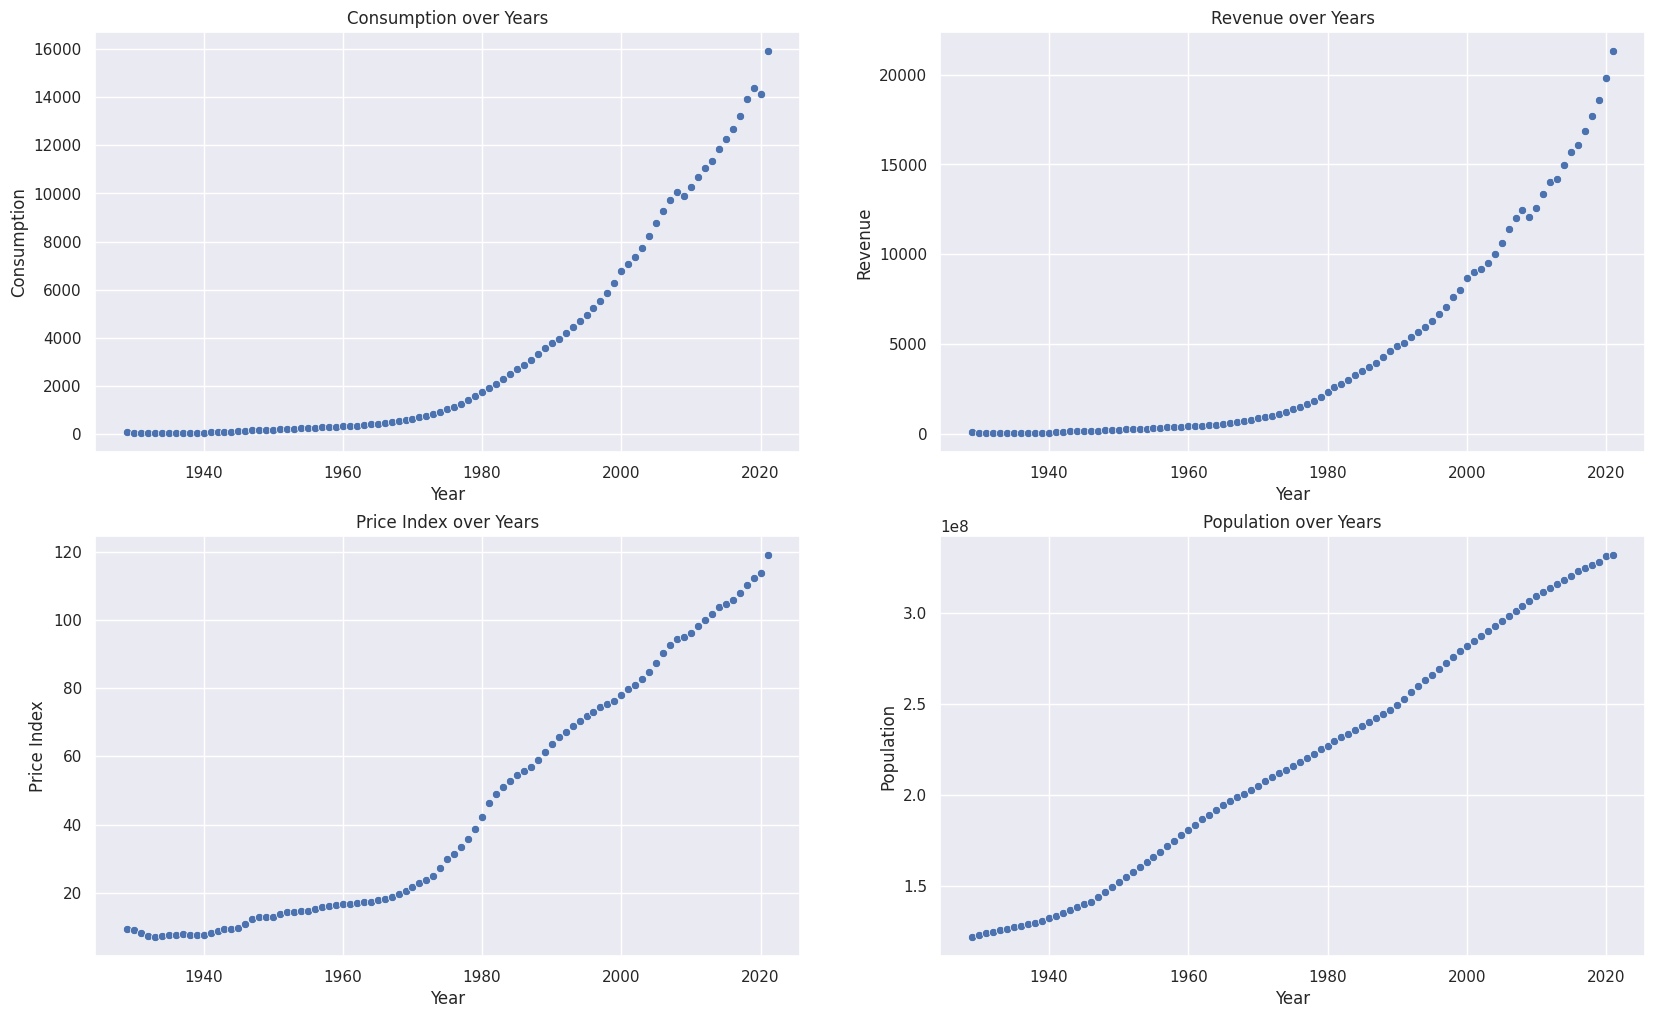

In [6]:
# Plotting the variables against Year in a scatterplot

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

sns.scatterplot(data=data, x='Year', y='Consumption', ax=axes[0, 0])
axes[0, 0].set_title('Consumption over Years')

sns.scatterplot(data=data, x='Year', y='Revenue', ax=axes[0, 1])
axes[0, 1].set_title('Revenue over Years')

sns.scatterplot(data=data, x='Year', y='Price Index', ax=axes[1, 0])
axes[1, 0].set_title('Price Index over Years')

sns.scatterplot(data=data, x='Year', y='Population', ax=axes[1, 1])
axes[1, 1].set_title('Population over Years')

# Feature Engineering

After visualizing the relationship between the variables, we found strong correlation between the variables. For example, the increase in population drives the increase in both Consumption and Revenue. Therefore, we will transform Consumption and Revenue into consumption per capita and revenue per capita.

Also, the increase in Price Index leads to higher Consumption and Revenue (because things are more expensive now). So we will adjust inflation based on Price Index.

In addition, we will derive a Trend-squared feature from Trend. This is because we noticed consumption per capita and revenue per capita show a curvilinear relationship with Year.

In [7]:
# added features
data['consump_rev_ratio'] = round(data['Consumption']/data['Revenue'],2)
data['cpc'] = round(data['Consumption']/data['Population']*10**10,2) # consumption per capita
data['rpc'] = round(data['Revenue']/data['Population']*10**10,2) # revenue per capita
data['cpc_adjusted'] = data['cpc']/data['Price Index']*100 # adjusting consumption per capita based on price index
data['rpc_adjusted'] = data['rpc']/data['Price Index']*100 # adjusting revenue per capita based on price index
data['trend2'] = data['Trend']*data['Trend']
data.head()

,Year,Consumption,Revenue,Population,Price Index,Trend,consump_rev_ratio,cpc,rpc,cpc_adjusted,rpc_adjusted,trend2
0,1929,77.4,85.3,121767000,9.391,1,0.91,6356.40,7005.18,67686.082419,74594.611862,1
1,1930,70.1,76.5,123076741,9.028,2,0.92,5695.63,6215.63,63088.502437,68848.360656,4
2,1931,60.7,65.7,124039648,8.136,3,0.92,4893.60,5296.69,60147.492625,65101.892822,9
3,1932,48.7,50.3,124840471,7.209,4,0.97,3900.98,4029.14,54112.636982,55890.414759,16
4,1933,45.9,47.2,125578763,7.014,5,0.97,3655.08,3758.60,52111.206159,53587.111491,25


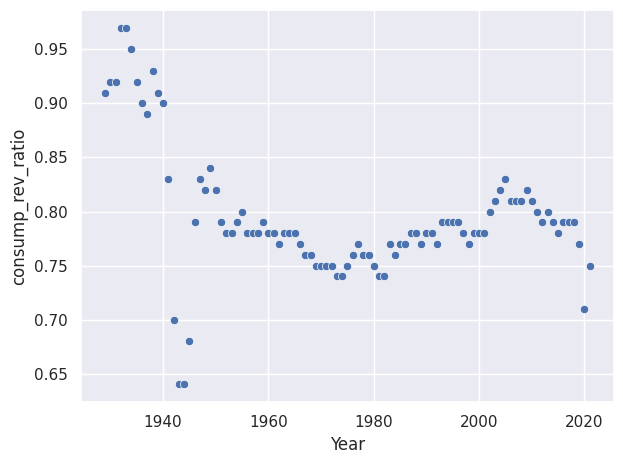

In [8]:
# Plotting consumption-revenew ratio against Year in a scatterplot

sns.scatterplot(data=data, x='Year', y='consump_rev_ratio')

plt.tight_layout()
plt.show()


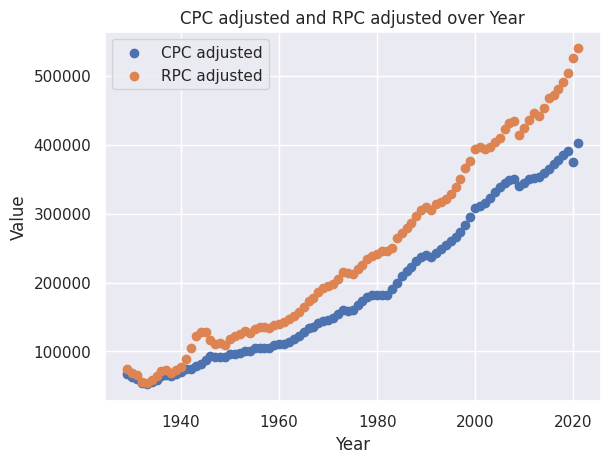

In [9]:

# Create the scatter plot
plt.scatter(data['Year'], data['cpc_adjusted'], label='CPC adjusted')
plt.scatter(data['Year'], data['rpc_adjusted'], label='RPC adjusted')

# Set plot title and axis labels
plt.title('CPC adjusted and RPC adjusted over Year')
plt.xlabel('Year')
plt.ylabel('Value')

# Add a legend
plt.legend()

# Display the plot
plt.show()

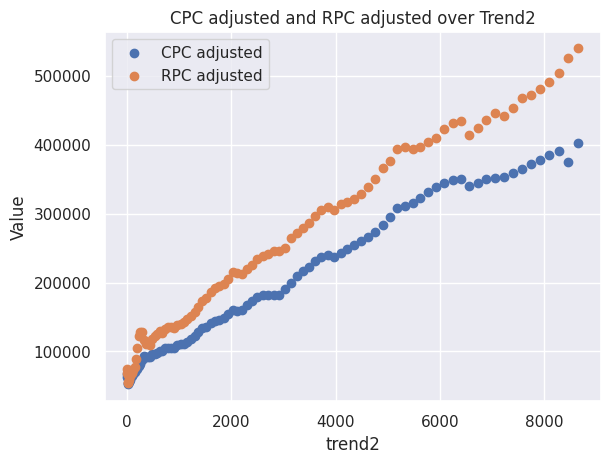

In [10]:

# Create the scatter plot
plt.scatter(data['trend2'], data['cpc_adjusted'], label='CPC adjusted')
plt.scatter(data['trend2'], data['rpc_adjusted'], label='RPC adjusted')

# Set plot title and axis labels
plt.title('CPC adjusted and RPC adjusted over Trend2')
plt.xlabel('trend2')
plt.ylabel('Value')

# Add a legend
plt.legend()

# Display the plot
plt.show()

**Inflation-adjusted consumption per capita and inflation-adjusted revenue per capita have a more linear relationship with Trend-squared.**

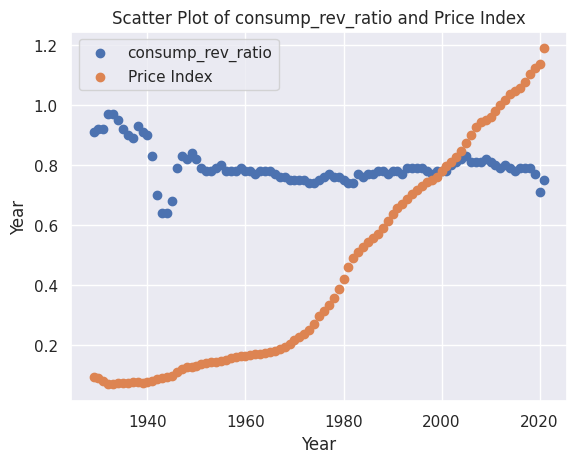

In [11]:
# Is consumption_revenue ratio related to price index?

# Create the scatter plot
plt.scatter(data['Year'], data['consump_rev_ratio'], label='consump_rev_ratio')
plt.scatter(data['Year'], data['Price Index']/100, label='Price Index')

# Set plot title and axis labels
plt.title('Scatter Plot of consump_rev_ratio and Price Index')
plt.xlabel('Year')
plt.ylabel('Year')

# Add a legend
plt.legend()

# Display the plot
plt.show()

# Linear Regressions

In [12]:
data.columns

Index(['Year', 'Consumption', 'Revenue', 'Population', 'Price Index', 'Trend',
       'consump_rev_ratio', 'cpc', 'rpc', 'cpc_adjusted', 'rpc_adjusted',
       'trend2'],
      dtype='object')

In [13]:
# We can't use consump_rev_ratio as one of the features because we want to predict consumption.
data_cleaned_1 = data[['cpc_adjusted','Price Index', 'Trend','trend2','rpc_adjusted']]

## Standarize the data

In [15]:
# Standardize the predictors
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_cleaned_1)

# Convert back to DataFrame
scaled_data = pd.DataFrame(scaled_data, columns=data_cleaned_1.columns)


## Split the data into training and validation

In [16]:
# Split the data into training and validation sets
train_data, validation_data = train_test_split(scaled_data, test_size=0.2, random_state=42)

# Separate predictors and target variable for both training and validation data
train_x = train_data.drop(columns=['cpc_adjusted'])
train_y = train_data['cpc_adjusted']

validation_x = validation_data.drop(columns=['cpc_adjusted'])
validation_y = validation_data['cpc_adjusted']

## Perform linear regressions on various combinations of independent variables

In [17]:
# Regression using all predictors: 'Price Index', 'Trend','trend2','rpc_adjusted'

# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model with the training data
model.fit(train_x, train_y)

# Predict the target variable for the validation data
predictions = model.predict(validation_x)

# Calculate r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(validation_y, predictions)
mse = mean_squared_error(validation_y, predictions)

# Store the metrics in a dataframe
metrics_df = pd.DataFrame({'r2_score': [r2], 'mean_squared_error': [mse]}, index=['Model 1 all'])

metrics_df


,r2_score,mean_squared_error
Model 1 all,0.998058,0.001629


In [18]:
# Run 4 simple regressions

# List of predictor variables
predictors = ['rpc_adjusted', 'Price Index', 'Trend', 'trend2']

# Initialize a counter for model numbering
counter = 2

# Loop through each predictor and fit a simple linear regression model
for predictor in predictors:
    # Fit the model
    model = LinearRegression()
    model.fit(train_x[[predictor]], train_y)

    # Make predictions on the validation set
    validation_predictions = model.predict(validation_x[[predictor]])

    # Calculate metrics
    mse = mean_squared_error(validation_y, validation_predictions)
    r2 = r2_score(validation_y, validation_predictions)

    # Store the model and metrics in the dictionary
    metrics_df.loc[f'Model {counter} (predictor: {predictor})'] = [r2, mse]
    counter += 1

metrics_df


,r2_score,mean_squared_error
Model 1 all,0.998058,0.001629
Model 2 (predictor: rpc_adjusted),0.997044,0.002479
Model 3 (predictor: Price Index),0.974723,0.021198
Model 4 (predictor: Trend),0.944471,0.046568
Model 5 (predictor: trend2),0.990927,0.007609


In [19]:
# run 4 more regression models, each time dropping a different predictor. So 3 predictors this time.
# List of predictors
predictors = list(train_x.columns)

# Initialize a counter for model numbering
counter = 6

# Loop through the predictors and drop each one in turn
for predictor in predictors:
    # Drop the predictor from the training and validation sets
    train_x_dropped = train_x.drop(columns=[predictor])
    validation_x_dropped = validation_x.drop(columns=[predictor])

    # Fit the model with the training data
    model.fit(train_x_dropped, train_y)

    # Predict the target variable for the validation data
    predictions = model.predict(validation_x_dropped)

    # Calculate r2_score, mean_absolute_error, mean_squared_error
    r2 = r2_score(validation_y, predictions)
    mse = mean_squared_error(validation_y, predictions)

    # Store the metrics in the dataframe
    metrics_df.loc[f'Model {counter} (Dropped: {predictor})'] = [r2, mse]
    counter += 1

metrics_df


,r2_score,mean_squared_error
Model 1 all,0.998058,0.001629
Model 2 (predictor: rpc_adjusted),0.997044,0.002479
Model 3 (predictor: Price Index),0.974723,0.021198
Model 4 (predictor: Trend),0.944471,0.046568
Model 5 (predictor: trend2),0.990927,0.007609
Model 6 (Dropped: Price Index),0.998171,0.001534
Model 7 (Dropped: Trend),0.998417,0.001328
Model 8 (Dropped: trend2),0.997934,0.001732
Model 9 (Dropped: rpc_adjusted),0.994544,0.004576


In [20]:
# run regressions with 2 predictors
from itertools import combinations

# List of predictor variables
predictors = ['rpc_adjusted', 'Price Index', 'Trend', 'trend2']

# Generate all combinations of 2 predictors
combinations_of_2 = list(combinations(predictors, 2))

counter = 10

# Loop through each combination and fit a multiple linear regression model
for combination in combinations_of_2:
    # Fit the model
    model = LinearRegression()
    model.fit(train_x[list(combination)], train_y)

    # Make predictions on the validation set
    validation_predictions = model.predict(validation_x[list(combination)])

    # Calculate metrics
    mse = mean_squared_error(validation_y, validation_predictions)
    r2 = r2_score(validation_y, validation_predictions)

    # Store the metrics in the DataFrame
    metrics_df.loc[f'Model {counter} (Predictors: {combination})'] = [r2, mse]
    counter += 1

metrics_df


,r2_score,mean_squared_error
Model 1 all,0.998058,0.001629
Model 2 (predictor: rpc_adjusted),0.997044,0.002479
Model 3 (predictor: Price Index),0.974723,0.021198
Model 4 (predictor: Trend),0.944471,0.046568
Model 5 (predictor: trend2),0.990927,0.007609
Model 6 (Dropped: Price Index),0.998171,0.001534
Model 7 (Dropped: Trend),0.998417,0.001328
Model 8 (Dropped: trend2),0.997934,0.001732
Model 9 (Dropped: rpc_adjusted),0.994544,0.004576
"Model 10 (Predictors: ('rpc_adjusted', 'Price Index'))",0.998317,0.001412


In [21]:
# sort metrics_df using the least squared error
metrics_df_sorted = metrics_df.sort_values(by=['mean_squared_error'])
metrics_df_sorted

,r2_score,mean_squared_error
Model 7 (Dropped: Trend),0.998417,0.001328
"Model 12 (Predictors: ('rpc_adjusted', 'trend2'))",0.998364,0.001372
"Model 10 (Predictors: ('rpc_adjusted', 'Price Index'))",0.998317,0.001412
Model 6 (Dropped: Price Index),0.998171,0.001534
Model 1 all,0.998058,0.001629
Model 8 (Dropped: trend2),0.997934,0.001732
"Model 11 (Predictors: ('rpc_adjusted', 'Trend'))",0.997558,0.002048
Model 2 (predictor: rpc_adjusted),0.997044,0.002479
"Model 15 (Predictors: ('Trend', 'trend2'))",0.994664,0.004475
Model 9 (Dropped: rpc_adjusted),0.994544,0.004576


winning model: predictors: trend2, rpc_adjusted

Examine the r-adjusted and other metrics using statsmodels.api

In [22]:
# winner model

# Define the target and predictor variables using the original dataset
y = scaled_data['cpc_adjusted']
X = scaled_data[['rpc_adjusted', 'trend2']]

# Add a constant to the predictor variables
X = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X)
results = model.fit()

# Get the summary of the model
summary = results.summary()
summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cpc_adjusted   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     9052.
Date:                Tue, 08 Aug 2023   Prob (F-statistic):          1.75e-104
Time:                        13:43:56   Log-Likelihood:                 114.91
No. Observations:                  93   AIC:                            -223.8
Df Residuals:                      90   BIC:                            -216.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.898e-16      0.007   2.56e-14      1.000      -0.015       0.015
rpc_adjusted     0.7157      0.064     11.153      0.000       0.588       0.843
trend2           0.2832      0.064      4.414      0.000       0.156       0.411
==============================================================================
Omnibus:                       42.457   Durbin-Watson:                   0.359
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.325
Skew:                          -1.248   Prob(JB):                     1.07e-52
Kurtosis:                      10.452   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# if I run the regression using original cpc and rpc values before scaling
# Define the target and predictor variables using the original dataset
y = data['cpc_adjusted']
X = data[['rpc_adjusted', 'trend2']]

# Add a constant to the predictor variables
X = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X)
results = model.fit()

# Get the summary of the model
summary = results.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cpc_adjusted   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     9052.
Date:                Tue, 08 Aug 2023   Prob (F-statistic):          1.75e-104
Time:                        13:43:58   Log-Likelihood:                -962.45
No. Observations:                  93   AIC:                             1931.
Df Residuals:                      90   BIC:                             1938.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.065e+04   4701.601      4.392      0.000    1.13e+04       3e+04
rpc_adjusted     0.5595      0.050     11.153      0.000       0.460       0.659
trend2          11.6806      2.647      4.414      0.000       6.423      16.938
==============================================================================
Omnibus:                       42.457   Durbin-Watson:                   0.359
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.325
Skew:                          -1.248   Prob(JB):                     1.07e-52
Kurtosis:                      10.452   Cond. No.                     1.65e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
# check multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

# To make this as easy as possible to use, we declare a variable where we put
# all features where we want to check for multicollinearity
# since our categorical data is not yet preprocessed, we will only take the numerical ones

variables = scaled_data[['trend2', 'rpc_adjusted']]

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif


,VIF,Features
0,74.917123,trend2
1,74.917123,rpc_adjusted


In [25]:
# check the results of simple regression using rpc_adjusted
# Define the target and predictor variables using the original dataset
y = scaled_data['cpc_adjusted']
X = scaled_data[['rpc_adjusted']]

# Add a constant to the predictor variables
X = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X)
results = model.fit()

# Get the summary of the model
summary = results.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cpc_adjusted   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.503e+04
Date:                Tue, 08 Aug 2023   Prob (F-statistic):          7.67e-103
Time:                        13:44:39   Log-Likelihood:                 105.80
No. Observations:                  93   AIC:                            -207.6
Df Residuals:                      91   BIC:                            -202.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.898e-16      0.008   2.33e-14      1.000      -0.016       0.016
rpc_adjusted     0.9970      0.008    122.607      0.000       0.981       1.013
==============================================================================
Omnibus:                       22.347   Durbin-Watson:                   0.375
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.769
Skew:                          -0.867   Prob(JB):                     4.24e-11
Kurtosis:                       6.053   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**This simple regression using only adjusted revenue per capita as the independent variable has almost the same explanainability as the model with 2 predictors (adjusted revenue per capita and trend-squared)**

# Examine Residuals

In [26]:
# are the residuals normally distributed?

predictors = ['rpc_adjusted','trend2']
# Fit the model
model = LinearRegression()
model.fit(scaled_data[predictors], scaled_data['cpc_adjusted'])

# Make predictions on the validation set
validation_predictions = model.predict(scaled_data[predictors])

scaled_data['pred'] = validation_predictions
scaled_data

,cpc_adjusted,Price Index,Trend,trend2,rpc_adjusted,pred
0,-1.152367,-1.002354,-1.713526,-1.124486,-1.234038,-1.201634
1,-1.195168,-1.012580,-1.676275,-1.123334,-1.275857,-1.231237
2,-1.222547,-1.037706,-1.639025,-1.121414,-1.303122,-1.250206
3,-1.278728,-1.063818,-1.601774,-1.118727,-1.370160,-1.297422
4,-1.297360,-1.069311,-1.564523,-1.115271,-1.386922,-1.308440
...,...,...,...,...,...,...
88,1.734470,1.768061,1.564523,1.916464,1.721645,1.774897
89,1.806849,1.841327,1.601774,1.985193,1.791555,1.844394
90,1.851347,1.896509,1.639025,2.054689,1.891643,1.935707
91,1.700580,1.939071,1.676275,2.124954,2.048516,2.067876


In [27]:
# examine residuals
scaled_data['residual'] = scaled_data['cpc_adjusted'] - scaled_data['pred']
scaled_data['diff%'] = scaled_data['residual']/scaled_data['cpc_adjusted']*100
scaled_data['residual_abs'] = scaled_data['residual'].abs()

In [28]:
scaled_data['Year'] = data['Year']
scaled_data.describe()

,cpc_adjusted,Price Index,Trend,trend2,rpc_adjusted,pred,residual,diff%,residual_abs,Year
count,9.300000e+01,9.300000e+01,9.300000e+01,9.300000e+01,9.300000e+01,9.300000e+01,9.300000e+01,93.000000,93.000000,93.000000
mean,1.766807e-16,1.575800e-16,7.162729e-18,7.640244e-17,1.050534e-16,1.384794e-16,2.268198e-17,31.258207,0.045836,1975.000000
std,1.005420e+00,1.005420e+00,1.005420e+00,1.005420e+00,1.005420e+00,1.002930e+00,7.071257e-02,256.502806,0.053633,26.990739
min,-1.297360e+00,-1.069311e+00,-1.713526e+00,-1.124486e+00,-1.386922e+00,-1.308440e+00,-3.672960e-01,-60.573155,0.000783,1929.000000
25%,-8.727726e-01,-8.656533e-01,-8.567628e-01,-9.037100e-01,-8.414399e-01,-8.719893e-01,-2.640903e-02,-1.932699,0.014053,1952.000000
50%,-2.922046e-01,-4.267056e-01,0.000000e+00,-2.767060e-01,-2.125851e-01,-2.428583e-01,-7.833140e-04,1.889450,0.027659,1975.000000
75%,8.543802e-01,8.519129e-01,8.567628e-01,7.565260e-01,8.910353e-01,8.519462e-01,2.847395e-02,7.259779,0.049268,1998.000000
max,1.968316e+00,2.083011e+00,1.713526e+00,2.195986e+00,2.149470e+00,2.160243e+00,1.841900e-01,2472.243438,0.367296,2021.000000


<ipython-input-29-82c279615e00>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scaled_data['residual'])


<Axes: xlabel='residual', ylabel='Density'>

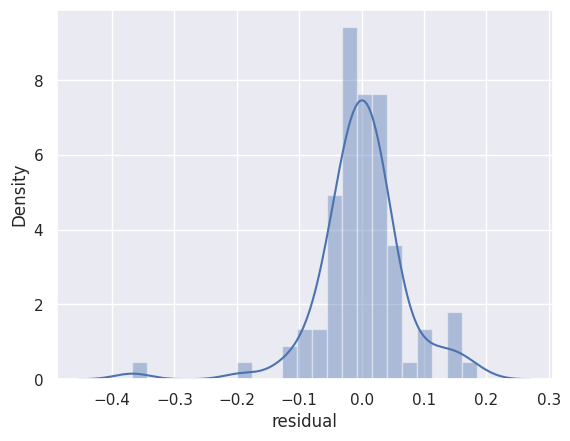

In [29]:
# plot residuals in histogram
sns.distplot(scaled_data['residual'])

In [30]:
# what are the outlier years when it comes to residual?
# calculate avg and std of absolute residual.

avg_residual = scaled_data['residual_abs'].mean()
print(avg_residual)

std_residual = scaled_data['residual_abs'].std()
print(std_residual)

0.04583647991787007
0.053632528684514943


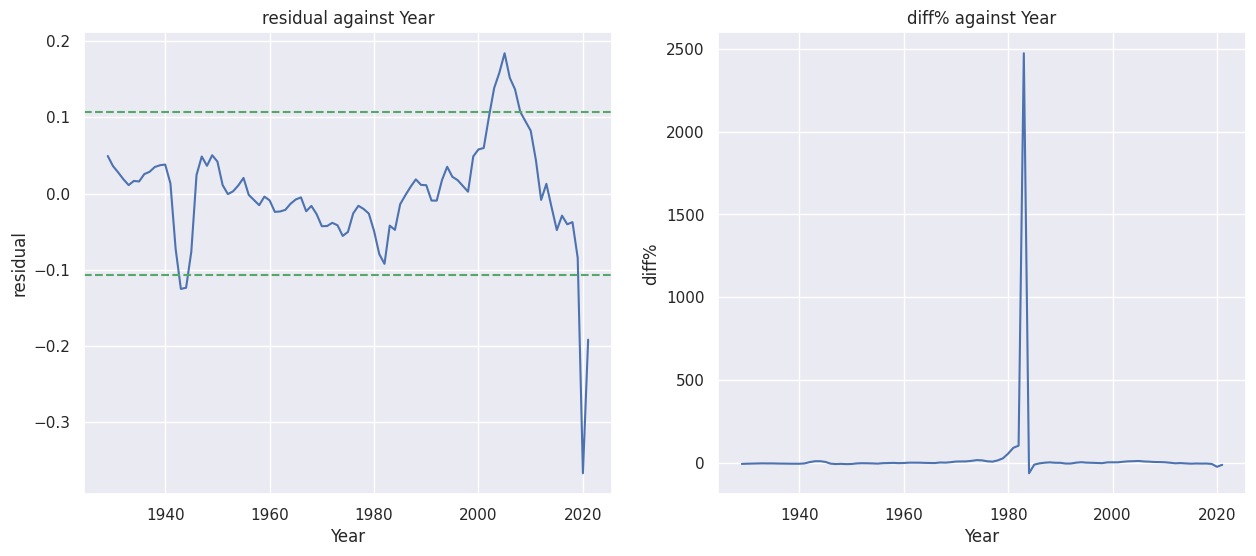

In [31]:
# plot residuals and diff% over Year

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First plot for residual against Year
axs[0].plot(scaled_data['Year'], scaled_data['residual'])
axs[0].axhline(y=std_residual*2, color='g', linestyle='--') # Add horizontal line at y=0.05
axs[0].axhline(y=-std_residual*2, color='g', linestyle='--') # Add horizontal line at y=-0.05
axs[0].set_xlabel('Year')
axs[0].set_ylabel('residual')
axs[0].set_title('residual against Year')
axs[0].grid(True)

# Second plot for diff against Year
axs[1].plot(scaled_data['Year'], scaled_data['diff%']) # replace 'diff' with the correct column name
axs[1].set_xlabel('Year')
axs[1].set_ylabel('diff%') # replace 'diff' with the correct label
axs[1].set_title('diff% against Year') # replace 'diff' with the correct title
axs[1].grid(True)

# Display the figure containing both plots
plt.show()



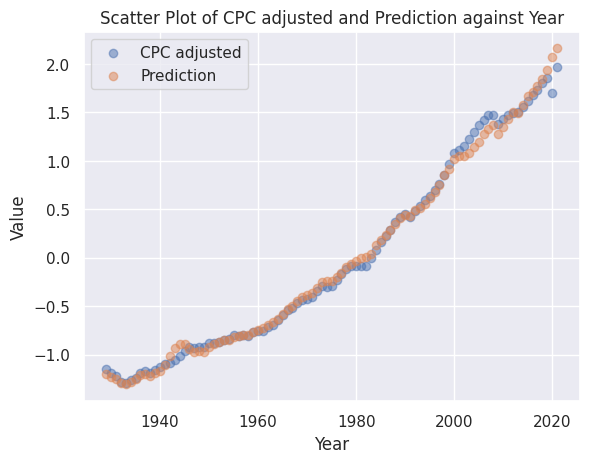

In [32]:
#plot predicted value over actual value
# use trend2 as x-axis
# Create the scatter plot
plt.scatter(scaled_data['Year'], scaled_data['cpc_adjusted'], label='CPC adjusted',alpha=0.5)
plt.scatter(scaled_data['Year'], scaled_data['pred'], label='Prediction',alpha=0.5)

# Set plot title and axis labels
plt.title('Scatter Plot of CPC adjusted and Prediction against Year')
plt.xlabel('Year')
plt.ylabel('Value')

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [33]:
# years when the residuals are more than 1 std
outliers = scaled_data[scaled_data['residual_abs']>std_residual]
outliers

,cpc_adjusted,Price Index,Trend,trend2,rpc_adjusted,pred,residual,diff%,residual_abs,Year
13,-1.091325,-1.016495,-1.229268,-1.049614,-1.007725,-1.018463,-0.072862,6.676490,0.072862,1942
14,-1.052257,-1.004523,-1.192018,-1.038479,-0.884345,-0.927010,-0.125247,11.902681,0.125247,1943
15,-1.016432,-0.998270,-1.154767,-1.026577,-0.841124,-0.892707,-0.123725,12.172513,0.123725,1944
16,-0.965664,-0.991566,-1.117517,-1.013906,-0.841440,-0.889344,-0.076320,7.903326,0.076320,1945
45,-0.298780,-0.498112,-0.037251,-0.312414,-0.216028,-0.243084,-0.055696,18.641079,0.055696,1974
52,-0.085632,0.035622,0.223503,-0.046331,0.009890,-0.006043,-0.079588,92.942769,0.079588,1981
53,-0.087227,0.116155,0.260754,-0.005247,0.009206,0.005103,-0.092330,105.849863,0.092330,1982
71,1.079389,0.930700,0.931264,0.865570,1.084742,1.021460,0.057929,5.366874,0.057929,2000
72,1.112861,0.981347,0.968515,0.921244,1.106926,1.053103,0.059758,5.369754,0.059758,2001
73,1.153576,1.015120,1.005765,0.977686,1.084262,1.052868,0.100708,8.730056,0.100708,2002


Basically the model does not fit the 21st centry data very well.

2020 is also a huge outlier. Take it out of the data all together.

### Split the data into 2 periods: before 2000 and after 2000 and re-run regressions



In [35]:
scaled_data_bf = scaled_data[scaled_data['Year']<2000]
data_bf = data[data['Year']<2000]

In [36]:
scaled_data_af = scaled_data[(scaled_data['Year']>=2000) & (scaled_data['Year']!=2020)]
data_af = data[(data['Year']>=2000) & (data['Year']!=2020)]

In [37]:
scaled_data_bf.describe()

,cpc_adjusted,Price Index,Trend,trend2,rpc_adjusted,pred,residual,diff%,residual_abs,Year
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,-0.462184,-0.456200,-0.409756,-0.465997,-0.451474,-0.455083,-0.007101,40.192866,0.029698,1964.000000
std,0.629068,0.634803,0.768843,0.588777,0.652122,0.632324,0.038645,293.443860,0.025494,20.639767
min,-1.297360,-1.069311,-1.713526,-1.124486,-1.386922,-1.308440,-0.125247,-60.573155,0.000783,1929.000000
25%,-0.926206,-0.939469,-1.061641,-0.993364,-0.922336,-0.935575,-0.025150,-1.697298,0.011198,1946.500000
50%,-0.641910,-0.774923,-0.409756,-0.627260,-0.629898,-0.628448,-0.002175,1.328246,0.023281,1964.000000
75%,-0.085244,0.075888,0.242129,-0.025789,0.009548,-0.000470,0.018645,6.454224,0.041838,1981.500000
max,0.966137,0.881574,0.894013,0.810664,0.960973,0.917331,0.050257,2472.243438,0.125247,1999.000000


In [38]:
data_bf.describe()

,Year,Consumption,Revenue,Population,Price Index,Trend,consump_rev_ratio,cpc,rpc,cpc_adjusted,rpc_adjusted,trend2
count,71.000000,71.000000,71.000000,7.100000e+01,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.00000
mean,1964.000000,1328.630986,1715.404225,1.904930e+08,28.779944,36.000000,0.794930,55493.885775,71642.837465,141823.806386,182125.507412,1716.00000
std,20.639767,1721.005929,2206.684505,4.829831e+07,22.536027,20.639767,0.068136,63834.046091,81985.974703,67572.966460,89607.021507,1533.43888
min,1929.000000,45.900000,47.200000,1.217670e+08,7.014000,1.000000,0.640000,3655.080000,3758.600000,52111.206159,53587.111491,1.00000
25%,1946.500000,153.050000,188.500000,1.427573e+08,11.623500,18.500000,0.760000,10716.030000,13201.410000,91979.708489,117425.167071,342.50000
50%,1964.000000,410.600000,528.200000,1.918890e+08,17.465000,36.000000,0.780000,21397.790000,27526.330000,122518.121958,157608.531348,1296.00000
75%,1981.500000,2002.650000,2698.350000,2.305650e+08,47.669500,53.500000,0.795000,86846.150000,117015.455000,182313.772600,245473.786191,2862.50000
max,1999.000000,6283.800000,8006.800000,2.790400e+08,76.272000,71.000000,0.970000,225193.520000,286940.940000,295250.576883,376207.441787,5041.00000


In [39]:
scaled_data_af.describe()

,cpc_adjusted,Price Index,Trend,trend2,rpc_adjusted,pred,residual,diff%,residual_abs,Year
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,1.481642,1.450052,1.305543,1.474327,1.428863,1.440143,0.041499,3.567526,0.085091,2010.047619
std,0.238749,0.324014,0.234257,0.397125,0.290574,0.317574,0.095088,6.342824,0.056987,6.288690
min,1.079389,0.930700,0.931264,0.865570,1.084262,1.021460,-0.191927,-9.750847,0.008377,2000.000000
25%,1.374984,1.197567,1.117517,1.151619,1.208154,1.190794,-0.029059,-1.731938,0.040427,2005.000000
50%,1.474140,1.441899,1.303770,1.456866,1.386478,1.369632,0.057929,5.366874,0.082480,2010.000000
75%,1.618448,1.681274,1.490022,1.781311,1.623542,1.666410,0.107216,8.730056,0.136779,2015.000000
max,1.968316,2.083011,1.713526,2.195986,2.149470,2.160243,0.184190,13.395789,0.191927,2021.000000


In [40]:
data_af.describe()

,Year,Consumption,Revenue,Population,Price Index,Trend,consump_rev_ratio,cpc,rpc,cpc_adjusted,rpc_adjusted,trend2
count,21.000000,21.000000,21.000000,2.100000e+01,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,2010.047619,10595.490476,13345.104762,3.080425e+08,96.453429,82.047619,0.796667,340932.594762,429087.274286,350624.828526,440499.501568,6769.476190
std,6.288690,2530.681167,3453.741449,1.536028e+07,11.502771,6.288690,0.018797,65131.057935,90275.701457,25645.812464,39927.311638,1034.291575
min,2000.000000,6767.200000,8655.900000,2.821624e+08,78.016000,72.000000,0.750000,239833.500000,306770.130000,307415.786505,393148.395936,5184.000000
25%,2005.000000,8769.100000,10604.900000,2.955166e+08,87.490000,77.000000,0.790000,296737.980000,358859.710000,339167.882044,410172.259687,5929.000000
50%,2010.000000,10260.300000,12594.500000,3.093271e+08,96.164000,82.000000,0.800000,331697.370000,410320.540000,349819.024624,434675.402820,6724.000000
75%,2015.000000,12263.500000,15685.200000,3.207390e+08,104.662000,87.000000,0.810000,382351.390000,489033.150000,365320.163956,467249.957004,7569.000000
max,2021.000000,15902.600000,21294.800000,3.318937e+08,118.924000,93.000000,0.830000,479147.320000,641614.980000,402902.122364,539516.817463,8649.000000


##Regression before 2000

In [41]:
# Define the target and predictor variables using the original dataset
y = scaled_data_bf['cpc_adjusted']
X = scaled_data_bf[['rpc_adjusted', 'trend2']]

# Add a constant to the predictor variables
X = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X)
results = model.fit()

# Get the summary of the model
summary = results.summary()
summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cpc_adjusted   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.277e+04
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           2.66e-88
Time:                        13:49:48   Log-Likelihood:                 143.21
No. Observations:                  71   AIC:                            -280.4
Df Residuals:                      68   BIC:                            -273.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0052      0.006      0.924      0.359      -0.006       0.017
rpc_adjusted     0.4787      0.045     10.738      0.000       0.390       0.568
trend2           0.5393      0.049     10.921      0.000       0.441       0.638
==============================================================================
Omnibus:                        2.678   Durbin-Watson:                   0.432
Prob(Omnibus):                  0.262   Jarque-Bera (JB):                1.901
Skew:                          -0.344   Prob(JB):                        0.387
Kurtosis:                       3.413   Cond. No.                         22.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
# are the residuals normally distributed?

predictors = ['rpc_adjusted','trend2']
# Fit the model
model = LinearRegression()
model.fit(scaled_data_bf[predictors], scaled_data_bf['cpc_adjusted'])

# Make predictions on the validation set
validation_predictions = model.predict(scaled_data_bf[predictors])

scaled_data_bf['pred'] = validation_predictions
scaled_data_bf

<ipython-input-42-f9b9a9b03fd7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data_bf['pred'] = validation_predictions


,cpc_adjusted,Price Index,Trend,trend2,rpc_adjusted,pred,residual,diff%,residual_abs,Year
0,-1.152367,-1.002354,-1.713526,-1.124486,-1.234038,-1.191901,0.049268,-4.275350,0.049268,1929
1,-1.195168,-1.012580,-1.676275,-1.123334,-1.275857,-1.211299,0.036069,-3.017915,0.036069,1930
2,-1.222547,-1.037706,-1.639025,-1.121414,-1.303122,-1.223316,0.027659,-2.262428,0.027659,1931
3,-1.278728,-1.063818,-1.601774,-1.118727,-1.370160,-1.253958,0.018694,-1.461896,0.018694,1932
4,-1.297360,-1.069311,-1.564523,-1.115271,-1.386922,-1.260119,0.011079,-0.853984,0.011079,1933
...,...,...,...,...,...,...,...,...,...,...
66,0.633303,0.756140,0.745011,0.598719,0.617289,0.623600,0.021963,3.467996,0.021963,1995
67,0.695743,0.793126,0.782262,0.650553,0.690101,0.686408,0.017613,2.531522,0.017613,1996
68,0.758484,0.828815,0.819512,0.703156,0.767594,0.751871,0.009997,1.317982,0.009997,1997
69,0.854380,0.851913,0.856763,0.756526,0.891035,0.839744,0.002434,0.284883,0.002434,1998


<ipython-input-43-b8d7977bcfe1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data_bf['residual'] = scaled_data_bf['cpc_adjusted'] - scaled_data_bf['pred']
<ipython-input-43-b8d7977bcfe1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data_bf['diff%'] = scaled_data_bf['residual']/scaled_data_bf['cpc_adjusted']*100
<ipython-input-43-b8d7977bcfe1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

<Axes: xlabel='residual', ylabel='Density'>

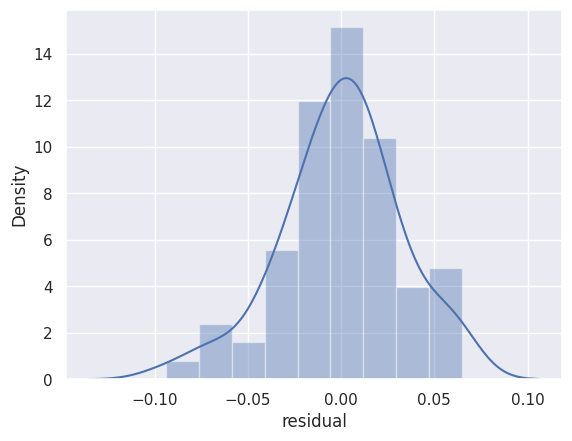

In [43]:
# examine residuals
scaled_data_bf['residual'] = scaled_data_bf['cpc_adjusted'] - scaled_data_bf['pred']
scaled_data_bf['diff%'] = scaled_data_bf['residual']/scaled_data_bf['cpc_adjusted']*100
scaled_data_bf['residual_abs'] = scaled_data_bf['residual'].abs()

# plot residuals in histogram
sns.distplot(scaled_data_bf['residual'])

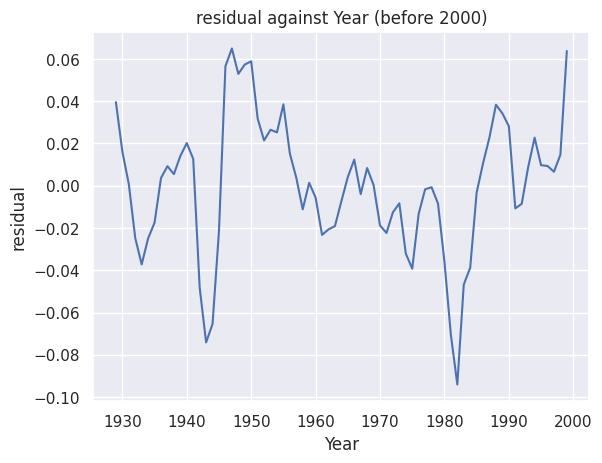

In [44]:
plt.plot(scaled_data_bf['Year'], scaled_data_bf['residual'])
plt.xlabel('Year')
plt.ylabel('residual')
plt.title('residual against Year (before 2000)')
plt.grid(True)
plt.show()

In [45]:
# regression using the un-scaled data
# Define the target and predictor variables using the original dataset
y = data_bf['cpc_adjusted']
X = data_bf[['rpc_adjusted', 'trend2']]

# Add a constant to the predictor variables
X = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X)
results = model.fit()

# Get the summary of the model
summary = results.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cpc_adjusted   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.277e+04
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           2.66e-88
Time:                        13:49:58   Log-Likelihood:                -679.28
No. Observations:                  71   AIC:                             1365.
Df Residuals:                      68   BIC:                             1371.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          3.55e+04   2953.069     12.022      0.000    2.96e+04    4.14e+04
rpc_adjusted     0.3742      0.035     10.738      0.000       0.305       0.444
trend2          22.2409      2.037     10.921      0.000      18.177      26.305
==============================================================================
Omnibus:                        2.678   Durbin-Watson:                   0.432
Prob(Omnibus):                  0.262   Jarque-Bera (JB):                1.901
Skew:                          -0.344   Prob(JB):                        0.387
Kurtosis:                       3.413   Cond. No.                     1.43e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model fits the 20th century model well.

## Regression after 2000, excluding 2020

In [46]:
# Define the target and predictor variables using the original dataset
y = scaled_data_af['cpc_adjusted']
X = scaled_data_af[['rpc_adjusted', 'trend2', 'Trend']]
# X = scaled_data_af[['rpc_adjusted', 'Trend']]

# Add a constant to the predictor variables
X = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X)
results = model.fit()

# Get the summary of the model
summary = results.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cpc_adjusted   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     272.5
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           1.44e-14
Time:                        13:50:18   Log-Likelihood:                 41.678
No. Observations:                  21   AIC:                            -75.36
Df Residuals:                      17   BIC:                            -71.18
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.0362      0.680     -2.993      0.008      -3.471      -0.601
rpc_adjusted     0.8402      0.147      5.720      0.000       0.530       1.150
trend2          -3.1544      0.938     -3.364      0.004      -5.133      -1.176
Trend            5.3372      1.460      3.655      0.002       2.256       8.418
==============================================================================
Omnibus:                        0.374   Durbin-Watson:                   0.770
Prob(Omnibus):                  0.829   Jarque-Bera (JB):                0.507
Skew:                           0.003   Prob(JB):                        0.776
Kurtosis:                       2.239   Cond. No.                         619.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# are the residuals normally distributed?

predictors = ['rpc_adjusted','trend2', 'Trend']
# Fit the model
model = LinearRegression()
model.fit(scaled_data_af[predictors], scaled_data_af['cpc_adjusted'])

# Make predictions on the validation set
validation_predictions = model.predict(scaled_data_af[predictors])

scaled_data_af['pred'] = validation_predictions
scaled_data_af

<ipython-input-47-1e1b1c3adb4f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data_af['pred'] = validation_predictions


,cpc_adjusted,Price Index,Trend,trend2,rpc_adjusted,pred,residual,diff%,residual_abs,Year
71,1.079389,0.930700,0.931264,0.865570,1.084742,1.115192,0.057929,5.366874,0.057929,2000
72,1.112861,0.981347,0.968515,0.921244,1.106926,1.157025,0.059758,5.369754,0.059758,2001
73,1.153576,1.015120,1.005765,0.977686,1.084262,1.158753,0.100708,8.730056,0.100708,2002
74,1.223459,1.060810,1.043016,1.034896,1.106582,1.195856,0.138415,11.313400,0.138415,2003
75,1.302407,1.122977,1.080266,1.092873,1.165595,1.261366,0.158708,12.185755,0.158708,2004
76,1.374984,1.197567,1.117517,1.151619,1.208154,1.310628,0.184190,13.395789,0.184190,2005
77,1.426055,1.274241,1.154767,1.211133,1.301136,1.399833,0.151861,10.649048,0.151861,2006
78,1.468523,1.343000,1.192018,1.271414,1.357696,1.456015,0.136779,9.314045,0.136779,2007
79,1.476848,1.392126,1.229268,1.332464,1.386478,1.486435,0.107216,7.259779,0.107216,2008
80,1.376502,1.409647,1.266519,1.394281,1.239172,1.366483,0.094785,6.885960,0.094785,2009


In [48]:
model.coef_

array([ 0.84020417, -3.15443055,  5.3371867 ])

<ipython-input-49-71e4cff5a26d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data_af['residual'] = scaled_data_af['cpc_adjusted'] - scaled_data_af['pred']
<ipython-input-49-71e4cff5a26d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data_af['diff%'] = scaled_data_af['residual']/scaled_data_af['cpc_adjusted']*100
<ipython-input-49-71e4cff5a26d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

<Axes: xlabel='residual', ylabel='Density'>

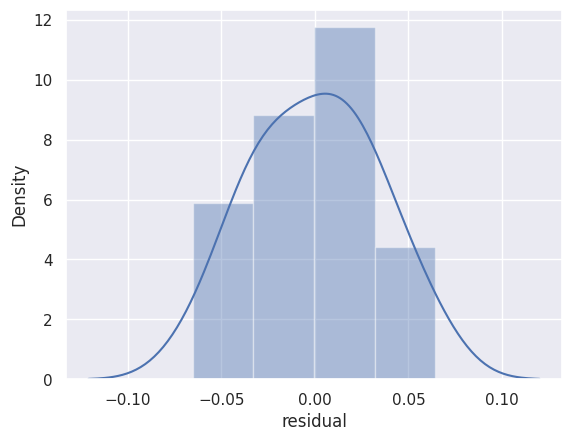

In [49]:
# examine residuals
scaled_data_af['residual'] = scaled_data_af['cpc_adjusted'] - scaled_data_af['pred']
scaled_data_af['diff%'] = scaled_data_af['residual']/scaled_data_af['cpc_adjusted']*100
scaled_data_af['residual_abs'] = scaled_data_af['residual'].abs()

# plot residuals in histogram
sns.distplot(scaled_data_af['residual'])

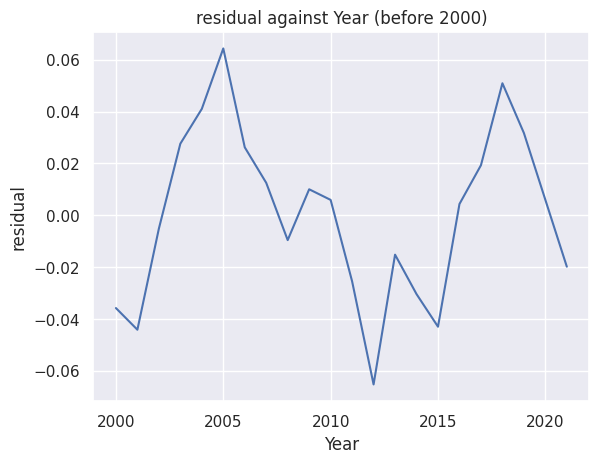

In [50]:
plt.plot(scaled_data_af['Year'], scaled_data_af['residual'])
plt.xlabel('Year')
plt.ylabel('residual')
plt.title('residual against Year (before 2000)')
plt.grid(True)
plt.show()

In [51]:
# using the pre-scaled data to run regression
y = data_af['cpc_adjusted']
X = data_af[['rpc_adjusted', 'trend2', 'Trend']]

# Add a constant to the predictor variables
X = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X)
results = model.fit()

# Get the summary of the model
summary = results.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cpc_adjusted   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     272.5
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           1.44e-14
Time:                        13:50:29   Log-Likelihood:                -201.60
No. Observations:                  21   AIC:                             411.2
Df Residuals:                      17   BIC:                             415.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -8.102e+05   2.55e+05     -3.176      0.006   -1.35e+06   -2.72e+05
rpc_adjusted     0.6568      0.115      5.720      0.000       0.415       0.899
trend2        -130.1009     38.670     -3.364      0.004    -211.688     -48.514
Trend         2.136e+04   5843.319      3.655      0.002    9027.698    3.37e+04
==============================================================================
Omnibus:                        0.374   Durbin-Watson:                   0.770
Prob(Omnibus):                  0.829   Jarque-Bera (JB):                0.507
Skew:                           0.003   Prob(JB):                        0.776
Kurtosis:                       2.239   Cond. No.                     1.30e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [52]:
predictors = ['rpc_adjusted','trend2', 'Trend']
# Fit the model
model = LinearRegression()
model.fit(data_af[predictors], data_af['cpc_adjusted'])

# Make predictions on the validation set
validation_predictions = model.predict(data_af[predictors])

data_af['pred'] = validation_predictions
data_af

<ipython-input-52-1036149e36b5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_af['pred'] = validation_predictions


,Year,Consumption,Revenue,Population,Price Index,Trend,consump_rev_ratio,cpc,rpc,cpc_adjusted,rpc_adjusted,trend2,pred
71,2000,6767.2,8655.9,282162411,78.016,72,0.78,239833.50,306770.13,307415.786505,393214.379102,5184,311261.669697
72,2001,7073.8,9012.8,284968955,79.814,73,0.78,248230.55,316273.05,311011.288746,396262.623099,5329,315755.212428
73,2002,7348.9,9160.9,287625193,81.013,74,0.80,255502.65,318501.31,315384.753064,393148.395936,5476,315940.913517
74,2003,7740.7,9498.5,290107933,82.635,75,0.81,266821.38,327412.63,322891.486658,396215.441399,5625,319926.401825
75,2004,8232.0,10044.3,292805298,84.842,76,0.82,281142.45,343036.83,331371.785201,404324.308715,5776,326963.262272
76,2005,8769.1,10604.9,295516599,87.490,77,0.83,296737.98,358859.71,339167.882044,410172.259687,5929,332254.903810
77,2006,9277.2,11384.7,298379912,90.212,78,0.81,310919.05,381550.48,344653.760032,422948.698621,6084,341837.119213
78,2007,9746.6,12021.4,301231207,92.653,79,0.81,323558.77,399075.52,349215.643314,430720.559507,6241,347872.021366
79,2008,10050.1,12477.6,304093966,94.397,80,0.81,330493.24,410320.54,350109.897560,434675.402820,6400,351139.624804
80,2009,9891.2,12080.4,306771529,95.019,81,0.82,322428.88,393791.43,339330.954862,414434.407855,6561,338254.694243


In [53]:
model.coef_

array([ 6.56820897e-01, -1.30100905e+02,  2.13560236e+04])

In [54]:
model.intercept_

-810200.3582834001

This linear line fits the other years fine, but 2020 is unpredictable.